In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

✓ Structure vérifiée:
  Images de chiens: 12499
  Images de chats: 12499
Found 17500 images belonging to 2 classes.
Found 7498 images belonging to 2 classes.

VÉRIFICATION DES DONNÉES PRÉPARÉES
✓ Classes mapping: {'cat': 0, 'dog': 1}
✓ Images d'entraînement: 17500
✓ Images de validation: 7498
✓ Taille des batches: 32
✓ Taille des images: (150, 150)
✓ Total d'images: 24998

Visualisation des données...


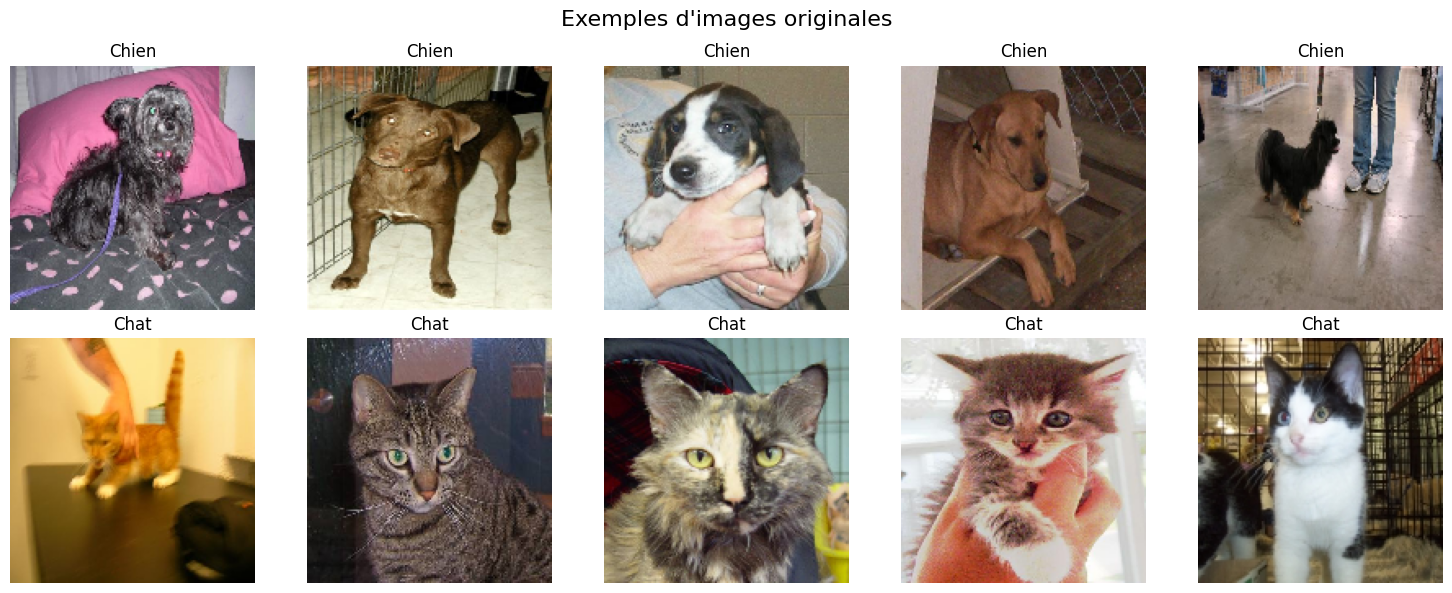

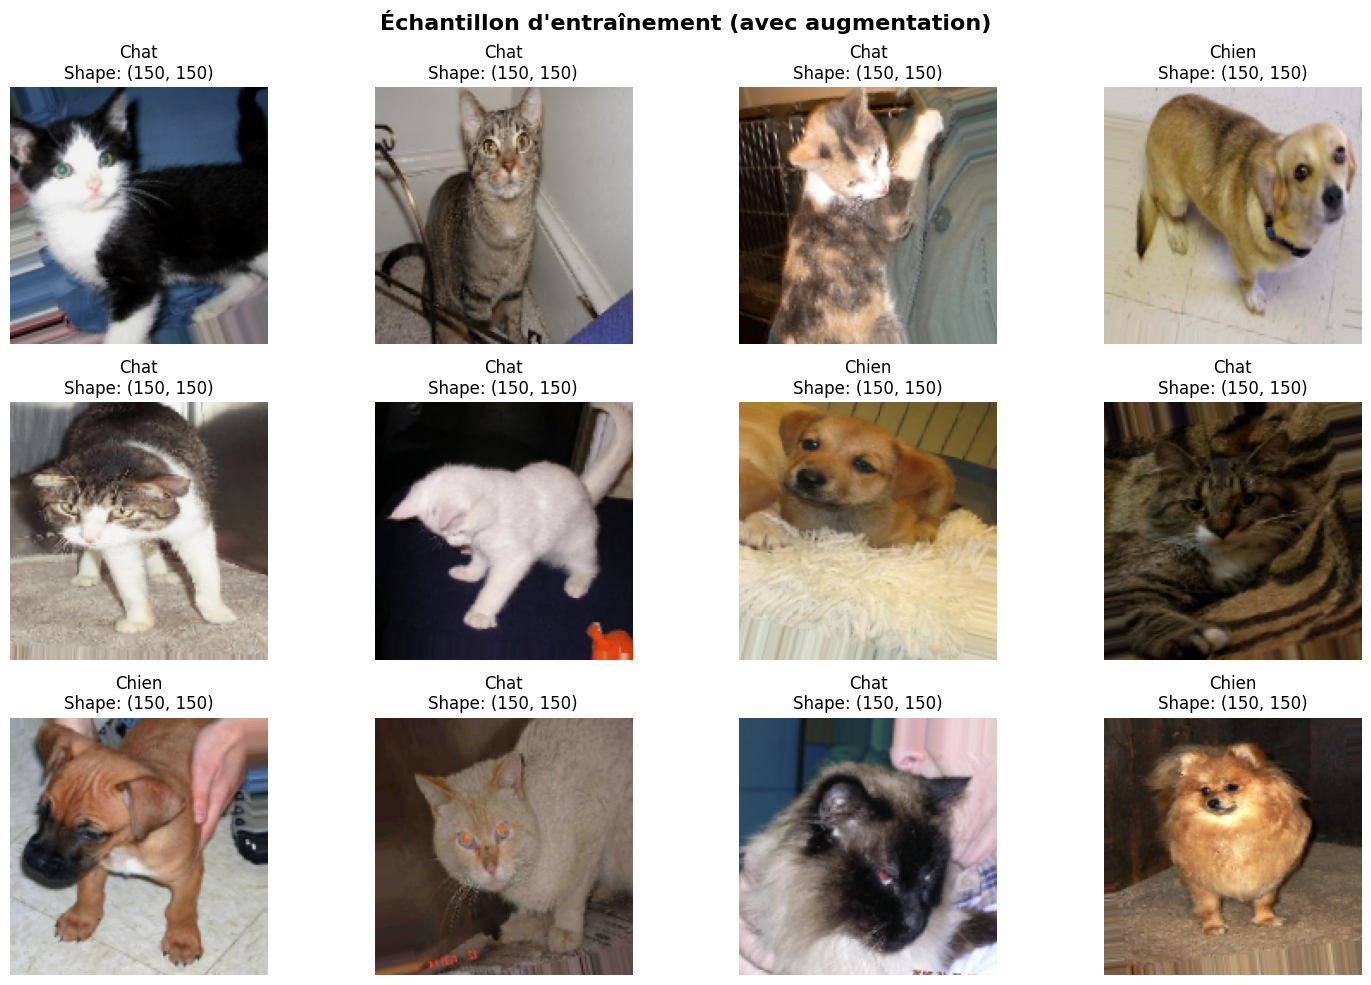

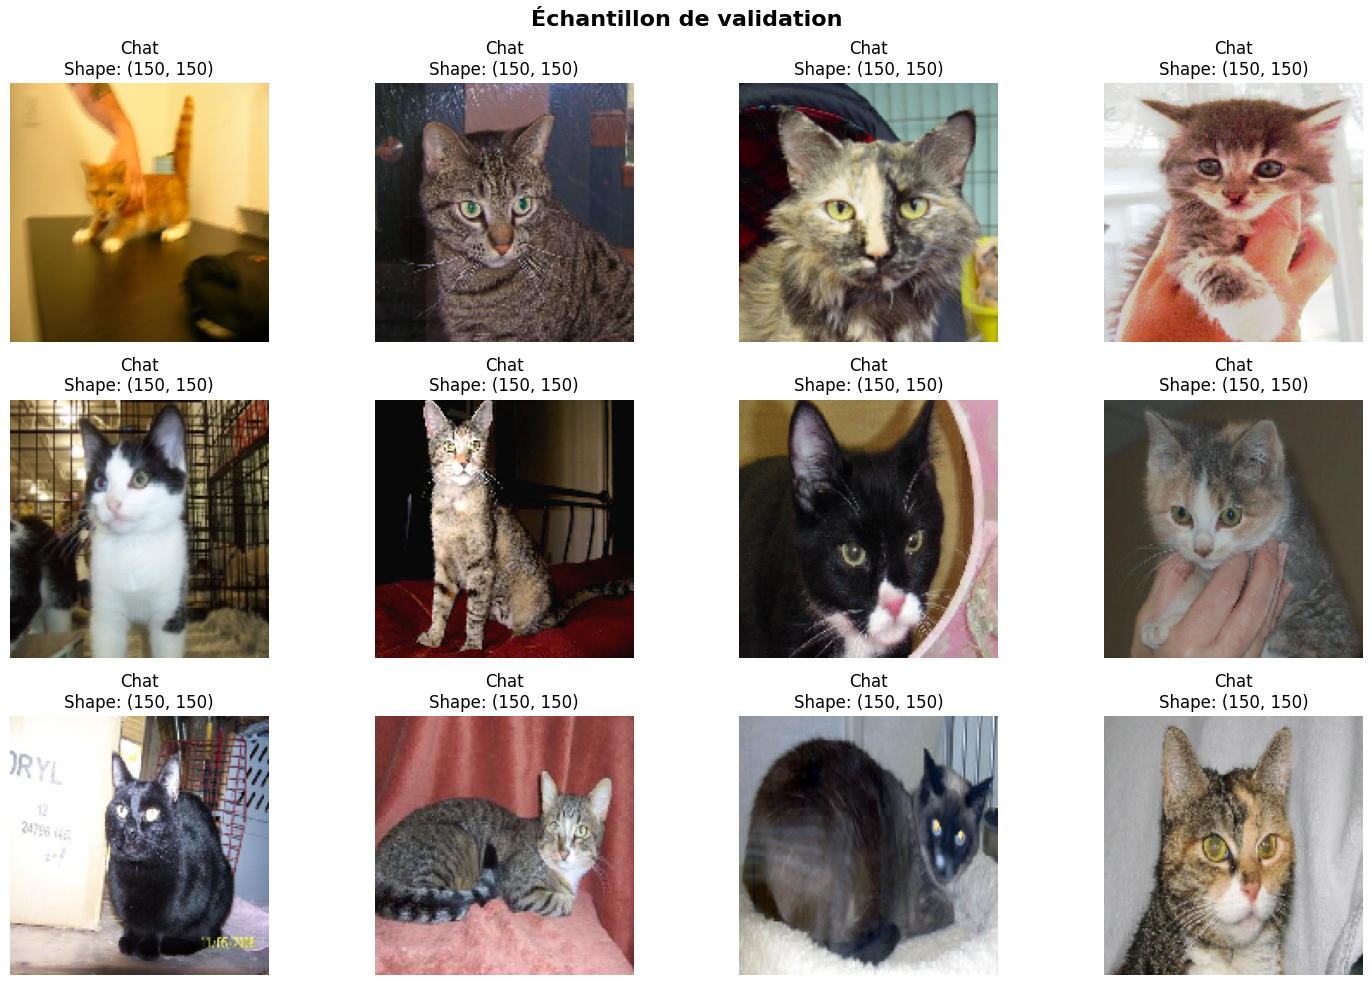


INFORMATIONS POUR L'ENTRAÎNEMENT
Steps par epoch (train): 546
Steps de validation: 234
Shape d'entrée du modèle: (150, 150, 3)

Test de chargement des données...
✓ Batch chargé avec succès
  Shape des images: (32, 150, 150, 3)
  Shape des labels: (32,)
  Valeurs min/max des images: 0.000/1.000
  Labels uniques: [0. 1.]

✅ PRÉPARATION DES DONNÉES TERMINÉE !
✅ VOS DONNÉES SONT PRÊTES POUR L'ENTRAÎNEMENT


In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

# ==================== CONFIGURATION ====================
DATA_DIR = 'E:/Data/dataset/PetImages'  # Dossier parent avec dog/ et cat/
IMG_SIZE = (150, 150)                # Taille des images
BATCH_SIZE = 32                      # Taille des batches
VAL_SPLIT = 0.3                      # 30% pour la validation
SEED = 42                            # Seed pour la reproductibilité

# ==================== VÉRIFICATION DE LA STRUCTURE ====================

def verify_structure(data_dir):
    """Vérifie la structure des dossiers"""
    dog_dir = os.path.join(data_dir, 'dog')
    cat_dir = os.path.join(data_dir, 'cat')
    
    if not os.path.exists(dog_dir):
        raise ValueError(f"Dossier 'dog' introuvable dans {data_dir}")
    if not os.path.exists(cat_dir):
        raise ValueError(f"Dossier 'cat' introuvable dans {data_dir}")
    
    # Compter les images
    dog_images = [f for f in os.listdir(dog_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    cat_images = [f for f in os.listdir(cat_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"✓ Structure vérifiée:")
    print(f"  Images de chiens: {len(dog_images)}")
    print(f"  Images de chats: {len(cat_images)}")
    
    return dog_dir, cat_dir, dog_images, cat_images

# Vérifier la structure
dog_dir, cat_dir, dog_files, cat_files = verify_structure(DATA_DIR)

# ==================== PRÉPARATION DES GÉNÉRATEURS ====================

def create_data_generators(data_dir, img_size, batch_size, val_split=0.2):
    """
    Crée les générateurs de données directement depuis la structure existante
    """
    # Data Augmentation pour l'entraînement
    train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalisation [0,1]
        rotation_range=20,        # Rotation aléatoire
        width_shift_range=0.1,    # Déplacement horizontal
        height_shift_range=0.1,   # Déplacement vertical
        shear_range=0.1,          # Cisaillement
        zoom_range=0.1,           # Zoom aléatoire
        horizontal_flip=True,     # Retournement horizontal
        brightness_range=[0.9, 1.1], # Variation de luminosité
        fill_mode='nearest',      # Remplissage des bords
        validation_split=val_split  # Split pour validation
    )
    
    # Préprocessing pour la validation (sans augmentation)
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split
    )
    
    # Générateur d'entraînement
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',      # binary pour 2 classes
        shuffle=True,
        seed=SEED,
        color_mode='rgb',         # Images couleur
        subset='training'         # Sous-ensemble d'entraînement
    )
    
    # Générateur de validation
    validation_generator = val_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,           # Pas de shuffle pour la validation
        color_mode='rgb',
        subset='validation'      # Sous-ensemble de validation
    )
    
    return train_generator, validation_generator

# Créer les générateurs
train_gen, val_gen = create_data_generators(DATA_DIR, IMG_SIZE, BATCH_SIZE, VAL_SPLIT)

# ==================== VÉRIFICATION DES DONNÉES ====================

print("\n" + "="*50)
print("VÉRIFICATION DES DONNÉES PRÉPARÉES")
print("="*50)

print(f"✓ Classes mapping: {train_gen.class_indices}")
print(f"✓ Images d'entraînement: {train_gen.samples}")
print(f"✓ Images de validation: {val_gen.samples}")
print(f"✓ Taille des batches: {BATCH_SIZE}")
print(f"✓ Taille des images: {IMG_SIZE}")

# Calculer l'équilibre des classes
total_samples = train_gen.samples + val_gen.samples
print(f"✓ Total d'images: {total_samples}")

# ==================== VISUALISATION ====================

def visualize_samples(generator, title, num_samples=12):
    """Visualise un échantillon d'images"""
    images, labels = next(generator)
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        class_name = 'Chien' if labels[i] > 0.5 else 'Chat'
        plt.title(f'{class_name}\nShape: {images[i].shape[:2]}')
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def show_sample_images(dog_dir, cat_dir, num_samples=5):
    """Montre des exemples d'images originales"""
    dog_images = [f for f in os.listdir(dog_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    cat_images = [f for f in os.listdir(cat_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    plt.figure(figsize=(15, 6))
    
    # Afficher des chiens
    for i in range(min(num_samples, len(dog_images))):
        img_path = os.path.join(dog_dir, dog_images[i])
        img = image.load_img(img_path, target_size=IMG_SIZE)
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title('Chien')
        plt.axis('off')
    
    # Afficher des chats
    for i in range(min(num_samples, len(cat_images))):
        img_path = os.path.join(cat_dir, cat_images[i])
        img = image.load_img(img_path, target_size=IMG_SIZE)
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(img)
        plt.title('Chat')
        plt.axis('off')
    
    plt.suptitle('Exemples d\'images originales', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualiser les données
print("\nVisualisation des données...")
show_sample_images(dog_dir, cat_dir)
visualize_samples(train_gen, "Échantillon d'entraînement (avec augmentation)")
visualize_samples(val_gen, "Échantillon de validation")

# ==================== INFORMATIONS POUR L'ENTRAÎNEMENT ====================

print("\n" + "="*50)
print("INFORMATIONS POUR L'ENTRAÎNEMENT")
print("="*50)

# Calcul des steps par epoch
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

print(f"Steps par epoch (train): {train_steps}")
print(f"Steps de validation: {val_steps}")
print(f"Shape d'entrée du modèle: ({IMG_SIZE[0]}, {IMG_SIZE[1]}, 3)")


# ==================== TEST DE CHARGEUR ====================

def test_data_loading():
    """Test que les données se chargent correctement"""
    print("\nTest de chargement des données...")
    
    # Charger un batch
    images, labels = next(train_gen)
    
    print(f"✓ Batch chargé avec succès")
    print(f"  Shape des images: {images.shape}")
    print(f"  Shape des labels: {labels.shape}")
    print(f"  Valeurs min/max des images: {images.min():.3f}/{images.max():.3f}")
    print(f"  Labels uniques: {np.unique(labels)}")
    
    return True

# Tester le chargement
test_data_loading()

print("\n" + "="*50)
print("✅ PRÉPARATION DES DONNÉES TERMINÉE !")
print("✅ VOS DONNÉES SONT PRÊTES POUR L'ENTRAÎNEMENT")
print("="*50)

In [4]:
dog_dir_1 = os.path.join(DATA_DIR, 'cat')

In [5]:
dog_images = [f for f in os.listdir(dog_dir_1) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
cat_images = [f for f in os.listdir(cat_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [6]:
len(dog_images) + len(cat_images)

24998

In [7]:
next(train_gen)[0][1][0].shape

(150, 3)

In [8]:
# train_gen, val_gen

## Preparation du modele

In [9]:
modele = Sequential()

# Premiere couche de convolution
modele.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))

# Couche de pooling
modele.add(MaxPooling2D(pool_size=(2,2)))

# Regularisation
modele.add(Dropout(0.5))

# Deuxieme couche de convolution
modele.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# Couche de pooling
modele.add(MaxPooling2D(pool_size=(2,2)))

# Regularisation
modele.add(Dropout(0.5))

# Couche de flattening
modele.add(Flatten())

# Couche dense
modele.add(Dense(32,activation='relu'))

# Couche de sortie
modele.add(Dense(1,activation='sigmoid'))

modele.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

print(modele.summary())


e:\Data\script\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,654,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,692,993 (10.27 MB)

 Trainable params: 2,692,993 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

None


## Phase d'entrainnement

In [12]:

modele.fit(train_gen,
           steps_per_epoch=train_gen.samples // BATCH_SIZE,
           validation_data=val_gen,
           validation_steps=val_gen.samples // BATCH_SIZE,
           epochs=10)

Epoch 1/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 2/10
  1/546 ━━━━━━━━━━━━━━━━━━━━ 9:25 1s/step - accuracy: 0.3438 - loss: 0.6938

e:\Data\script\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


546/546 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - accuracy: 0.3438 - loss: 0.6938 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 3/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 847s 2s/step - accuracy: 0.5076 - loss: 0.6931 - val_accuracy: 0.5007 - val_loss: 0.6932
Epoch 4/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.4688 - loss: 0.6934 - val_accuracy: 0.5007 - val_loss: 0.6932
Epoch 5/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 6/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.5312 - loss: 0.6929 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 7/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 5247s 10s/step - accuracy: 0.4967 - loss: 0.6932 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 8/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.4993 - val_loss: 0.6931
Epoch 9/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step - accuracy: 0.4974 - loss: 0.6932 - val_accuracy:

In [11]:
import os
from PIL import Image
import shutil

def clean_image_directory(directory):
    """
    Supprime les images corrompues d'un dossier
    """
    corrupted_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_path = os.path.join(root, file)
                try:
                    # Essayer d'ouvrir l'image pour vérifier si elle est valide
                    with Image.open(file_path) as img:
                        img.verify()  # Vérifie la validité
                except (IOError, SyntaxError, Exception) as e:
                    print(f"Image corrompue: {file_path} - {e}")
                    os.remove(file_path)  # Supprimer l'image corrompue
                    corrupted_count += 1
    
    print(f"{corrupted_count} images corrompues supprimées")

# Nettoyer les dossiers
clean_image_directory(DATA_DIR+'/cat')
clean_image_directory(DATA_DIR+'/dog')

0 images corrompues supprimées
0 images corrompues supprimées


In [13]:
prediction = modele.predict(val_gen)

235/235 ━━━━━━━━━━━━━━━━━━━━ 55s 229ms/step


In [20]:
x = []
for i in prediction:
    if i not in x:
        x.append(i)

print(x)

[array([0.4983239], dtype=float32)]
